In [1]:
import collections
import itertools
import random
import requests
import multiprocessing

import pandas as pd

import numpy as np

from backend.config import config
from backend.lib.fetch import representative_points
from backend.lib.database.postgres import connect
from backend.lib.calculate import adequacy

import matplotlib
import matplotlib.pyplot as plt

try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)
pd.set_option('max_columns', 999)

In [2]:
all_service_areas = requests.get('http://52.53.130.100:8080/api/available-service-areas/').json()
service_area_ids = [sa[0] for sa in all_service_areas if sa[3] == 'TX']
raw_points = representative_points.fetch_representative_points(
    service_area_ids=service_area_ids, format_response=False
)

In [3]:
def dataframe_from_points(points):
    df = pd.DataFrame(points)
    df.drop(
        labels=['census_block', 'census_block_group', 'created_at', 'isodistancePolygon', 'updated_at'],
        axis=1,
        inplace=True
    )
    df['population'] = df['population'].apply(lambda d: d['1.0'])
    df['state'] = df['service_area_id'].apply(lambda s: s[:2].upper())
    return df

In [4]:
df = dataframe_from_points(raw_points)
df.head(3)

,census_tract,county,id,latitude,location,longitude,population,service_area_id,zip_code,state
0,48213951100,Anderson,166087,32.021217,0101000020E610000058CEFE7032FB57C098E86E3CB702...,-95.924954,24,tx_anderson_75751,75751,TX
1,48001951100,Anderson,158515,31.959976,0101000020E6100000307EFEA1F70158C0E09592FCC0F5...,-96.030739,30,tx_anderson_75751,75751,TX
2,48001951100,Anderson,158514,31.991356,0101000020E6100000D8DE5A6507FF57C0B0E8067FC9FD...,-95.984826,11,tx_anderson_75751,75751,TX


In [5]:
def fetch_demographics():
    engine = connect.create_db_engine()
    result = engine.execute("SELECT * FROM census_tract_demographics WHERE state = 'Texas';")
    df = pd.DataFrame(result.fetchall(), columns=result.keys())
    return df

In [6]:
demos = fetch_demographics()

In [7]:
demos.head(4)

,census_tract,state,county,total_pop,men,women,hispanic,white,black,native,asian,pacific,citizen,income,income_err,income_per_cap,income_per_cap_err,poverty,child_poverty,professional,service,office,construction,production,drive,carpool,transit,walk,other_transp,work_at_home,mean_commute,employed,private_work,public_work,self_employed,family_work,unemployment
0,48071990000,Texas,Chambers,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,48085031309,Texas,Collin,9088,4432,4656,19.7,55.7,14.6,1.0,6.7,0.0,6047,76190.0,6758.0,28636.0,2222.0,4.1,3.4,34.9,9.2,39.5,7.9,8.5,84.9,9.9,0.3,0.0,2.1,2.9,36.5,5040,81.9,14.6,3.5,0.0,7.7
2,48085031310,Texas,Collin,10126,4945,5181,15.5,70.9,7.5,0.8,2.2,0.0,6748,73562.0,6024.0,25668.0,2514.0,5.5,5.8,41.3,9.2,26.3,13.4,9.9,88.9,5.6,1.5,0.0,0.8,3.1,29.5,4925,84.9,8.3,6.8,0.0,8.4
3,48085031311,Texas,Collin,10936,5466,5470,16.8,69.4,6.5,0.2,3.4,0.0,7121,92754.0,13313.0,31976.0,2712.0,4.5,1.2,50.6,10.8,29.1,5.1,4.5,81.3,9.7,0.8,0.6,1.2,6.4,32.2,5677,84.7,12.4,2.9,0.0,4.5


In [8]:
points = pd.merge(
    df,
    demos[[col for col in demos.columns if col not in df.columns] + ['census_tract']], 
    how='inner',
    on='census_tract'
)

In [9]:
points[points['county'] == 'DeWitt'].head(5)

,census_tract,county,id,latitude,location,longitude,population,service_area_id,zip_code,state,total_pop,men,women,hispanic,white,black,native,asian,pacific,citizen,income,income_err,income_per_cap,income_per_cap_err,poverty,child_poverty,professional,service,office,construction,production,drive,carpool,transit,walk,other_transp,work_at_home,mean_commute,employed,private_work,public_work,self_employed,family_work,unemployment
38111,48469001400,DeWitt,130210,28.951810,0101000020E6100000343DE60BF34B58C0002EB7D7A9F3...,-97.186709,2,tx_dewitt_77905,77905,TX,8340,4206,4134,30.1,67.0,1.3,0.1,0.7,0.0,6365,73230.0,6111.0,31120.0,3509.0,8.8,8.2,30.6,11.2,26.2,20.3,11.8,86.1,8.0,2.1,0.3,0.4,3.1,28.4,4014,82.0,12.3,5.2,0.5,3.9
38181,48123970400,DeWitt,151929,29.076701,0101000020E6100000EC6C2F6CA45158C0604AD8AFA213...,-97.275661,160,tx_dewitt_77954,77954,TX,3837,1909,1928,26.1,71.0,2.4,0.1,0.0,0.0,2854,50363.0,14391.0,28506.0,4626.0,12.6,17.3,25.2,16.1,21.8,24.8,12.1,89.7,3.9,0.0,0.9,1.4,4.0,29.3,1704,77.6,14.6,7.8,0.0,4.2
38182,48123970400,DeWitt,151928,29.078742,0101000020E61000005045C8AB195358C000A12F762814...,-97.298442,495,tx_dewitt_77954,77954,TX,3837,1909,1928,26.1,71.0,2.4,0.1,0.0,0.0,2854,50363.0,14391.0,28506.0,4626.0,12.6,17.3,25.2,16.1,21.8,24.8,12.1,89.7,3.9,0.0,0.9,1.4,4.0,29.3,1704,77.6,14.6,7.8,0.0,4.2
38183,48123970400,DeWitt,151927,29.066180,0101000020E61000001856170E695258C0704AAF30F110...,-97.287662,25,tx_dewitt_77954,77954,TX,3837,1909,1928,26.1,71.0,2.4,0.1,0.0,0.0,2854,50363.0,14391.0,28506.0,4626.0,12.6,17.3,25.2,16.1,21.8,24.8,12.1,89.7,3.9,0.0,0.9,1.4,4.0,29.3,1704,77.6,14.6,7.8,0.0,4.2
38184,48123970400,DeWitt,151926,29.082330,0101000020E61000003C1B05FD2F5458C0E03614971315...,-97.315429,219,tx_dewitt_77954,77954,TX,3837,1909,1928,26.1,71.0,2.4,0.1,0.0,0.0,2854,50363.0,14391.0,28506.0,4626.0,12.6,17.3,25.2,16.1,21.8,24.8,12.1,89.7,3.9,0.0,0.9,1.4,4.0,29.3,1704,77.6,14.6,7.8,0.0,4.2


In [10]:
def get_latitude_longitude_from_csv(path):
    tmp = pd.read_csv(path)
    return [{'latitude': row[0], 'longitude': row[1]} for row in tmp[['Latitude', 'Longitude']].values.tolist()]

In [11]:
provider_locations=get_latitude_longitude_from_csv('../data/Texas/texas_abortion_clinics_address_post_hb2.csv')

In [12]:
engine = connect.create_db_engine()
adequacy_response = adequacy.calculate_adequacies(service_area_ids, locations=provider_locations, engine=engine)

In [13]:
closest_distance_by_point = {
    point['id']: point['distance_to_closest_provider'] for point in adequacy_response
}
points['distance_to_closest_provider'] = points.apply(
    axis=1,
    func=lambda row: closest_distance_by_point[row['id']]
)

In [14]:
points[points['county'] == 'Dallas'].head(4)

,census_tract,county,id,latitude,location,longitude,population,service_area_id,zip_code,state,total_pop,men,women,hispanic,white,black,native,asian,pacific,citizen,income,income_err,income_per_cap,income_per_cap_err,poverty,child_poverty,professional,service,office,construction,production,drive,carpool,transit,walk,other_transp,work_at_home,mean_commute,employed,private_work,public_work,self_employed,family_work,unemployment,distance_to_closest_provider
34195,48113013726,Dallas,185164,32.949584,0101000020E61000007019018CBC3658C0183862F88B79...,-96.855258,2753,tx_dallas_75001,75001,TX,2979,1438,1541,27.5,51.6,5.8,0.6,12.6,0.0,1887,81875.0,30814.0,44128.0,5465.0,2.6,0.0,49.4,9.4,29.6,2.9,8.7,83.4,3.8,1.8,2.1,0.8,8.2,21.0,2042,85.0,8.5,6.5,0.0,2.2,7.062153
34196,48113013726,Dallas,184732,32.940010,0101000020E6100000FC893B253A3658C0706E7D3F5278...,-96.847299,2044,tx_dallas_75244,75244,TX,2979,1438,1541,27.5,51.6,5.8,0.6,12.6,0.0,1887,81875.0,30814.0,44128.0,5465.0,2.6,0.0,49.4,9.4,29.6,2.9,8.7,83.4,3.8,1.8,2.1,0.8,8.2,21.0,2042,85.0,8.5,6.5,0.0,2.2,6.325604
34197,48113013805,Dallas,185163,32.933541,0101000020E6100000ECDCA7EFC43658C0C827F1477E77...,-96.855770,4823,tx_dallas_75001,75001,TX,3518,1792,1726,39.3,36.6,13.2,0.2,9.4,0.0,2189,43429.0,5997.0,32060.0,4510.0,21.4,31.0,46.6,16.4,24.6,5.4,7.0,87.3,4.7,0.8,1.4,1.5,4.2,21.4,2291,91.4,6.0,2.6,0.0,3.1,6.561423
34198,48113013806,Dallas,184730,32.940628,0101000020E61000002C2967BDB23558C018874F816678...,-96.839034,919,tx_dallas_75001,75001,TX,3241,1545,1696,10.3,51.2,12.2,0.0,22.2,0.0,2361,70325.0,5488.0,45734.0,4387.0,2.2,2.3,63.3,10.0,20.7,1.3,4.7,88.3,4.3,0.3,1.2,1.2,4.7,20.9,2293,84.0,10.6,5.2,0.2,2.4,5.936967


In [15]:
def get_access_category(distance):
    if distance <= 15.0:
        return 'ADEQUATE_15'
    elif distance <= 30.0:
        return 'ADEQUATE_30'
    elif distance <= 60.0:
        return 'ADEQUATE_60'
    else:
        return 'INADEQUATE'

points['label'] = points['distance_to_closest_provider'].apply(get_access_category)
points['dummy_weight'] = 100.0

In [16]:
def donut(df, weight_column):
    cols = ['population', weight_column, 'label']
    mini_df = points[cols].values.tolist()
    labels = ['ADEQUATE_15', 'ADEQUATE_30', 'ADEQUATE_60', 'INADEQUATE']
    
    size_by_label = collections.defaultdict(float)
    for row in mini_df:
        if row[0] and row[1] and row[0] < float('inf') and row[1] < float('inf'):
            size_by_label[row[2]] += (row[0] * row[1])/100.0

    sizes = [size_by_label[label] for label in labels]
    colors = ['midnightblue', 'cornflowerblue', 'darkorange', 'red']
    explode = (0, 0, 0, 0)  # explode a slice if required
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True)
        
#     #draw a circle at the center of pie to make it look like a donut
    centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=1.25)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.title('Texas Abortion Clinics - Post HB2 - {} population'.format(weight_column))
    plt.show()  

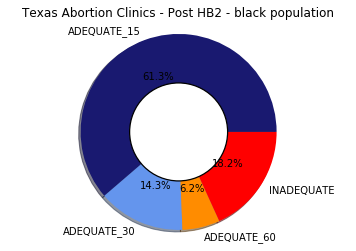

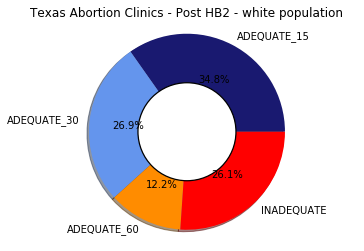

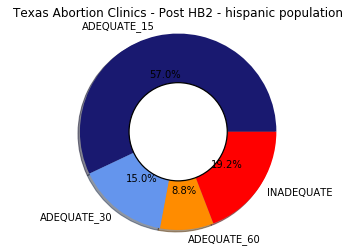

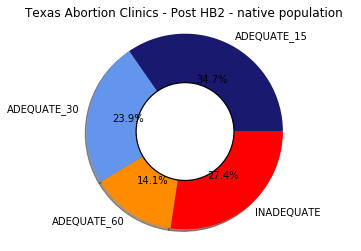

In [17]:
donut(points, 'black')
donut(points, 'white')
donut(points, 'hispanic')
donut(points, 'native')

In [18]:
float_cols = [
    col for col in points.columns if points.dtypes[col] == np.dtype('float64')
    if col not in {
        'latitude', 'longitude', 'income', 'income_err', 'income_per_cap', \
        'income_per_cap_err', 'distance_to_closest_provider', \
        'employed', 'mean_commute'
    }
]

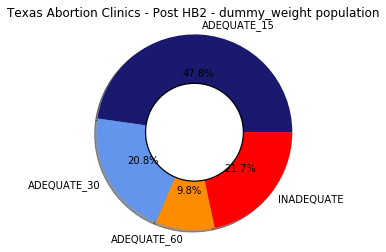

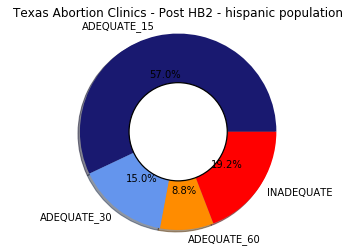

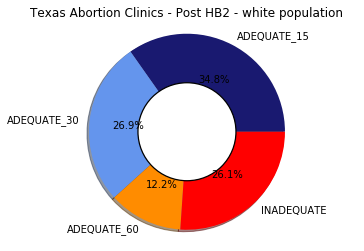

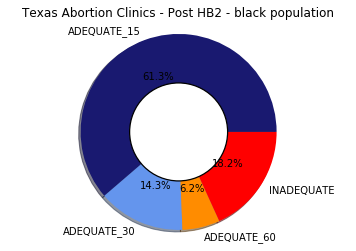

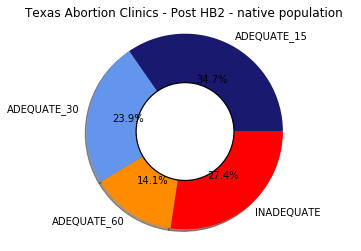

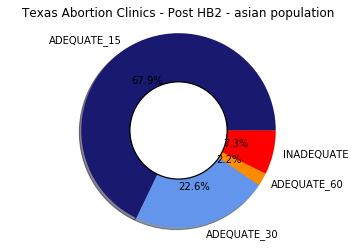

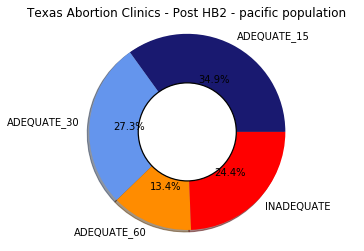

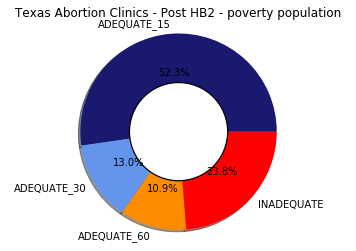

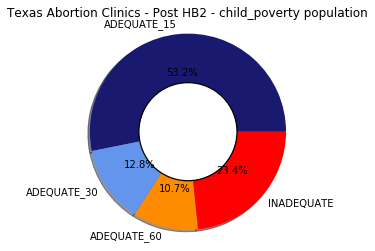

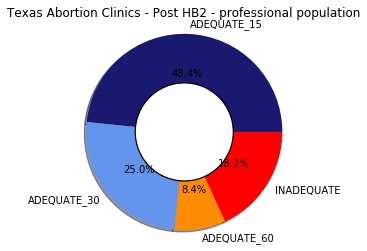

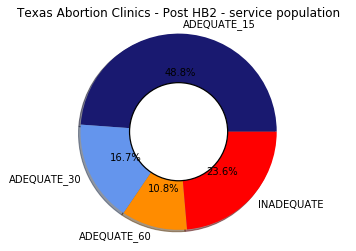

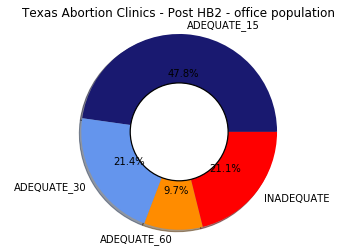

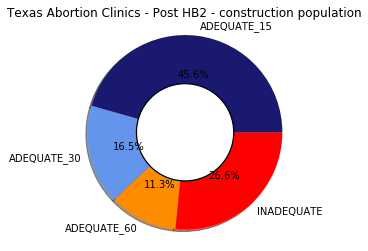

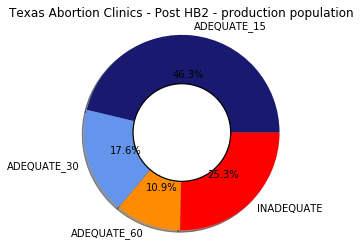

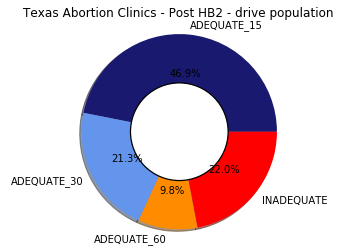

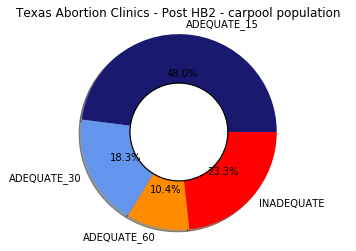

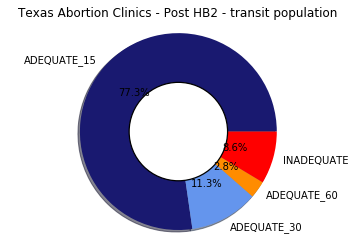

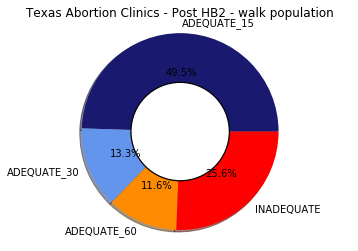

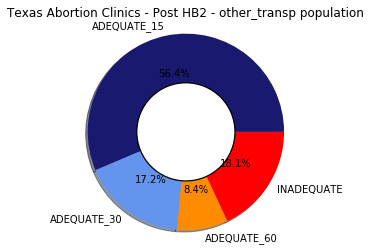

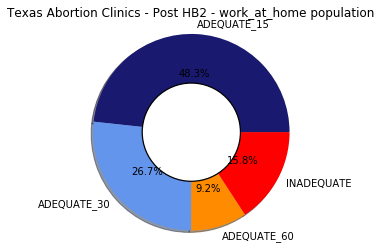

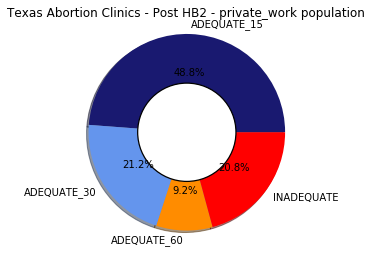

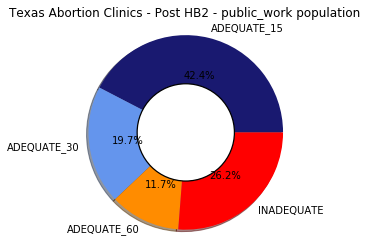

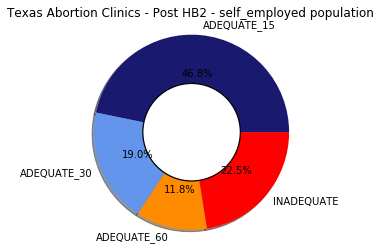

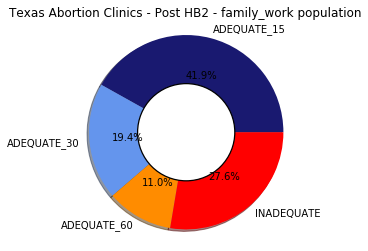

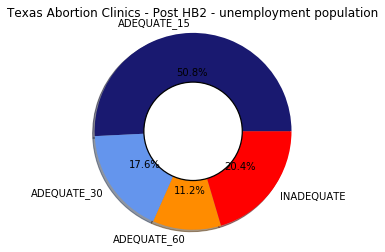

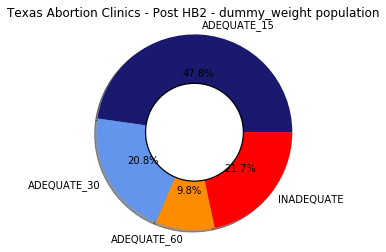

In [19]:
donut(points, 'dummy_weight')
for col in float_cols:
    donut(points, col)

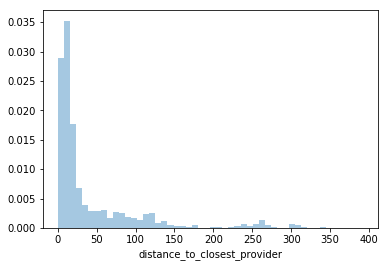

In [34]:
sns.distplot(
    a=points['distance_to_closest_provider'],
    kde=False,
    hist_kws={
        'weights': points['population'], 'normed': True
    },
)

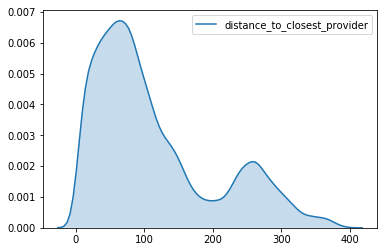

In [36]:
sns.kdeplot(points['distance_to_closest_provider'], shade=True)

In [47]:
def repeat_points_according_to_weight_population(data, weights):
    """Unspool the data, repeating each point according to its weight."""
    return_value = []
    for obs, weight in zip(data, weights):
        return_value.extend([obs]*int(weight+1))
    return pd.DataFrame(return_value)

In [48]:
large_df = repeat_points_according_to_weight_population(points['distance_to_closest_provider'], points['population'] / 20)

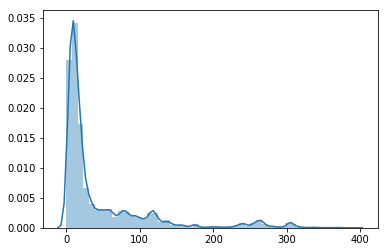

In [49]:
sns.distplot(
    a=large_df,
    kde=True,
    hist_kws={
        'normed': True
    },
)

In [46]:
large_df.shape

(3189909, 1)

In [73]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

points.fillna(0.0, inplace=True)
# Create the data
native_df = repeat_points_according_to_weight_population(
    data=points['distance_to_closest_provider'],
    weights=points['population']*points['native']/100/20
)
native_df['race'] = 'native'
asian_df = repeat_points_according_to_weight_population(
    data=points['distance_to_closest_provider'],
    weights=points['population']*points['asian']/100/20
)
asian_df['race'] = 'asian'

full_df = pd.concat([native_df, asian_df])

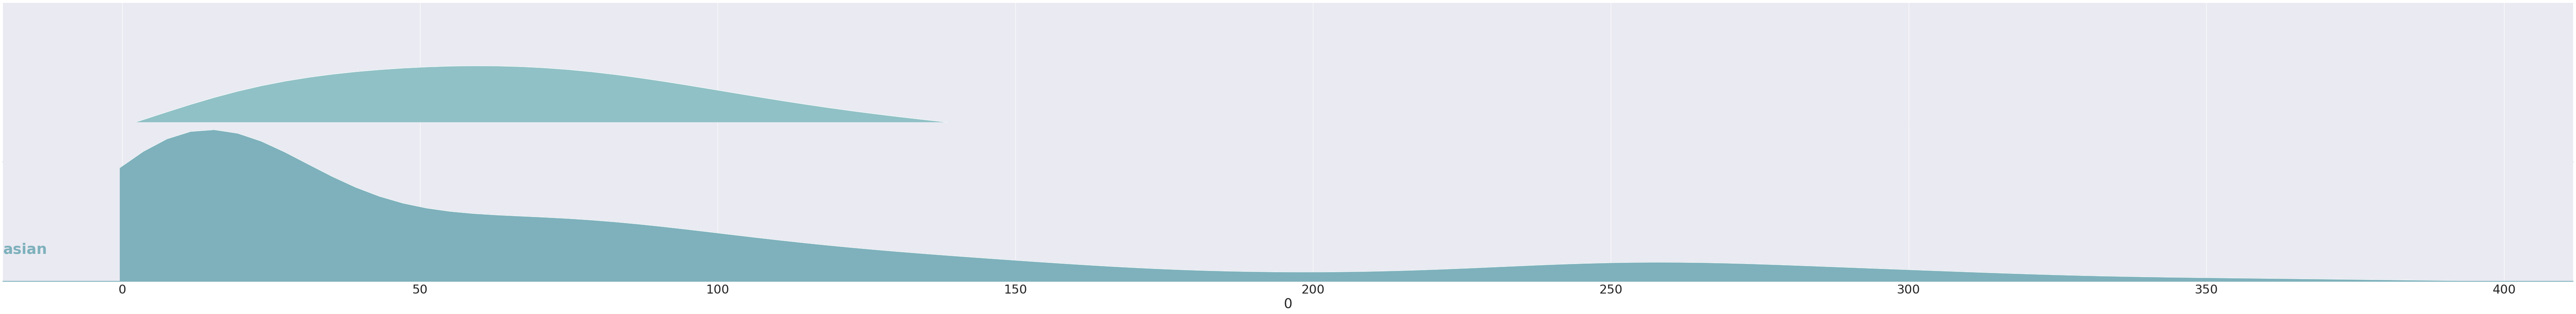

In [111]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(full_df, row='race', hue='race', aspect=15, size=6, palette=pal)
g.map(sns.kdeplot, 0, clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, 0, clip_on=False, color="w", lw=1.5, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontsize=36, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, 0)
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.show()

In [105]:
g.set_xticklabels